<a href="https://colab.research.google.com/github/gieeedreee/Domoplius_Scraper/blob/main/315.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 3: Machine Learning

## Sprint 1: Basic Machine Learning

## House prices regression competition

## Background

---

Participating in Kaggle competitions is an efficient way to learn some aspects of Machine Learning. You can read solutions made public by the others, participate in the discussions to talk about solution ideas and test them by submitting them for evaluation.

The metric used for evaluation can vary from competition to competition, but the idea remains the same - build a model that is as accurate as possible on the testing set. In industry, there are other factors to consider when building machine learning models - inference time, solution complexity, maintainability and so on. However, even though you only learn a subset of the required skills while participating in Kaggle competitions, it is quite a fun way to learn by doing it, so let's participate in one of the tutorial competitions now!

## The competition

In the previous notebooks, we learned about some very important ML topics:

- Optimizing an objective
- Training, validation, testing sets
- Feature engineering
- Logistic regression model
- Linear regression model
- Random forest model
- Interpreting the model by looking at the important features

In this notebook we will practice all the above concepts by participating in another Kaggle competition:

- https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview

Read the overview and look at the evaluation section (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation). The target to predict is a continuous variable and hence we will build regression models.

Give extra attention to the evaluation metric - the RMSE is computed between the logarithm of the predicted value and the logarithm of the observed sales price, not the raw prices.

Now look at the data section - inspect the columns that are available. Download the data and start with exploratory data analysis, similar to the one you used in the previous notebooks. Select some features, maybe do some feature engineering and build linear regression and random forest models using sklearn.

For help, you can look at some of the notebooks by other competitors. However, try to write code by yourself, as even though you will always be able to consult external resources while working as a professional, the main thing right now is to learn by first trying it yourself. These two notebooks could be useful:

- https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python for exploratory data analysis
- https://www.kaggle.com/marcelopesse/house-prices-machine-learning-with-sklearn using random forests for regression

---

## Concepts to explore

- Linear regression https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- Random forest regressor https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
- Root mean squared error https://en.wikipedia.org/wiki/Root-mean-square_deviation

## Requirements

- Train, validate (using a dedicated validation set) and submit a linear regression model
- Train, validate (using a dedicated validation set) and submit a random forest regressor model
- Achieve a score better than 0.14 on the public leaderboard

## Evaluation criteria

- Public leaderboard score
- How simple is the model
- Code quality

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import scipy.stats as stats
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_validate

In [3]:
test = pd.read_csv('/content/test.csv')
train = pd.read_csv('/content/train.csv')

In [4]:
train.describe(include="all")

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1452,1452.000000,1460,1460,1460,1423,1423,1422,1423,1460.000000,1422,1460.000000,1460.000000,1460.000000,1460,...,1460,1459,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,770,1379,1379.000000,1379,1460.000000,1460.000000,1379,1379,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,6,...,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,...,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,864,NaN,906,1282,647,649,1311,953,430,NaN,1256,NaN,NaN,NaN,1428,...,1365,1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,380,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.685262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.639726,NaN,46.549315,567.240411,1057.429452,NaN,...,NaN,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,NaN,1978.506164,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,181.066207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098091,NaN,161.319273,441.866955,438.705324,NaN,...,NaN,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,NaN,24.689725,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,...,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,NaN,1900.000000,NaN,0.0

# **EDA**

**Missing Values**

In [5]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [6]:
missing_values = missing_values_table(train)
missing_values.head()

Your selected dataframe has 81 columns.
There are 19 columns that have missing values.


,Missing Values,% of Total Values
PoolQC,1453,99.5
MiscFeature,1406,96.3
Alley,1369,93.8
Fence,1179,80.8
FireplaceQu,690,47.3


In [7]:
missing_values_test = missing_values_table(test)
missing_values_test.head()

Your selected dataframe has 80 columns.
There are 33 columns that have missing values.


,Missing Values,% of Total Values
PoolQC,1456,99.8
MiscFeature,1408,96.5
Alley,1352,92.7
Fence,1169,80.1
FireplaceQu,730,50.0


In [8]:
train.MSZoning.unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [9]:
test.GarageCars.unique()

array([ 1.,  2.,  3.,  0.,  4.,  5., nan])

In [10]:
new_train = train.copy()
new_test = test.copy()

In [11]:
new_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [12]:
columns_to_fill_zero = ['GarageYrBlt', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']
columns_to_fill_value = ['Electrical']

new_train[columns_to_fill_zero] = new_train[columns_to_fill_zero].fillna(0).astype(int)
new_test[columns_to_fill_zero] = new_test[columns_to_fill_zero].fillna(0).astype(int)

new_train['Electrical'].fillna(value='SBrkr', inplace = True)
new_test['Electrical'].fillna(value='SBrkr', inplace = True)

new_train['Exterior1st'].fillna(value='VinylSd', inplace = True)
new_test['Exterior1st'].fillna(value='VinylSd', inplace = True)

new_train['Exterior2nd'].fillna(value='Other', inplace = True)
new_test['Exterior2nd'].fillna(value='Other', inplace = True)

new_train['Functional'].fillna(value='Typ', inplace = True)
new_test['Functional'].fillna(value='Typ', inplace = True)

new_train['MSZoning'].fillna(value='RL', inplace = True)
new_test['MSZoning'].fillna(value='RL', inplace = True)

new_train['SaleType'].fillna(value='WD', inplace = True)
new_test['SaleType'].fillna(value='WD', inplace = True)

new_train['Utilities'].fillna(value='AllPub', inplace = True)
new_test['Utilities'].fillna(value='AllPub', inplace = True)


In [13]:
new_train_lotfrontage = new_train[['LotArea', 'LotFrontage']]
new_test_lotfrontage = new_test[['LotArea', 'LotFrontage']]

In [14]:
for_fill_train = new_train_lotfrontage.groupby('LotArea').mean()
for_fill_train.LotFrontage.fillna(method='ffill', inplace=True)

for_fill_test = new_test_lotfrontage.groupby('LotArea').mean()
for_fill_test.LotFrontage.fillna(method='ffill', inplace=True)

In [15]:
new_train_join = pd.merge(new_train,for_fill_train, on ='LotArea', how ='left')
new_train_join.loc[new_train_join['LotFrontage_x'].isnull(),'LotFrontage_x'] = new_train_join['LotFrontage_y']
new_train_join.drop(['LotFrontage_y'], axis=1, inplace=True)

new_test_join = pd.merge(new_test,for_fill_test, on ='LotArea', how ='left')
new_test_join.loc[new_test_join['LotFrontage_x'].isnull(),'LotFrontage_x'] = new_test_join['LotFrontage_y']
new_test_join.drop(['LotFrontage_y'], axis=1, inplace=True)

In [16]:
new_train_frontage = new_train_join.rename(columns={"LotFrontage_x": "LotFrontage"})
new_test_frontage = new_test_join.rename(columns={"LotFrontage_x": "LotFrontage"})

In [17]:
new_train_frontage.shape

(1460, 81)

In [18]:
new_test_frontage.shape

(1459, 80)

In [19]:
new_train_frontage.fillna(value='None', inplace = True)
new_test_frontage.fillna(value='None', inplace = True)

In [20]:
missing_values_train_new = missing_values_table(new_train_frontage)
missing_values_train_new.head()

Your selected dataframe has 81 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [21]:
missing_values_test_new = missing_values_table(new_test_frontage)
missing_values_test_new.head()

Your selected dataframe has 80 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [22]:
new_test.Exterior2nd.value_counts()

VinylSd    510
MetalSd    233
HdBoard    199
Wd Sdng    194
Plywood    128
CmentBd     66
Wd Shng     43
BrkFace     22
Stucco      21
AsbShng     18
Brk Cmn     15
ImStucc      5
CBlock       2
AsphShn      1
Other        1
Stone        1
Name: Exterior2nd, dtype: int64

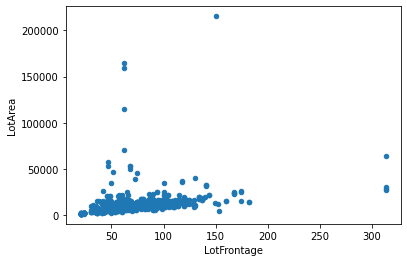

In [23]:
new_train_frontage.plot(kind='scatter', x='LotFrontage', y='LotArea')

In [24]:
test.GarageCars.unique()

array([ 1.,  2.,  3.,  0.,  4.,  5., nan])

**Reclassifying condition column**

In [25]:
new_test_frontage.BsmtExposure.unique()

array(['No', 'Gd', 'Mn', 'Av', 'None'], dtype=object)

In [26]:
# Reclassify condition column
ClassDict = {'Very Excellent': 10, 'Ex':9, 'Very Good':8, 'Gd':7, 'GLQ':7,'Above Average':6, 'TA':5, 'Av':5, 'ALQ':5, 'Below Average':4, 'BLQ':4, 
             'Fa':3, 'Mn':3, 'Rec':3, 'Po':2, 'LwQ':2,'Very Poor':1,'Unf':1,'None':0, 'No':0}

new_train_frontage['PoolQC'] = new_train_frontage.PoolQC.map(ClassDict)
new_train_frontage['ExterQual'] = new_train_frontage.ExterQual.map(ClassDict)
new_train_frontage['ExterCond'] = new_train_frontage.ExterCond.map(ClassDict)
new_train_frontage['BsmtQual'] = new_train_frontage.BsmtQual.map(ClassDict)
new_train_frontage['BsmtCond'] = new_train_frontage.BsmtCond.map(ClassDict)
new_train_frontage['HeatingQC'] = new_train_frontage.HeatingQC.map(ClassDict)
new_train_frontage['KitchenQual'] = new_train_frontage.KitchenQual.map(ClassDict)
new_train_frontage['FireplaceQu'] = new_train_frontage.FireplaceQu.map(ClassDict)
new_train_frontage['GarageQual'] = new_train_frontage.GarageQual.map(ClassDict)
new_train_frontage['GarageCond'] = new_train_frontage.GarageCond.map(ClassDict)
new_train_frontage['BsmtFinType1'] = new_train_frontage.BsmtFinType1.map(ClassDict)
new_train_frontage['BsmtExposure'] = new_train_frontage.BsmtExposure.map(ClassDict)

new_test_frontage['PoolQC'] = new_test_frontage.PoolQC.map(ClassDict)
new_test_frontage['ExterQual'] = new_test_frontage.ExterQual.map(ClassDict)
new_test_frontage['ExterCond'] = new_test_frontage.ExterCond.map(ClassDict)
new_test_frontage['BsmtQual'] = new_test_frontage.BsmtQual.map(ClassDict)
new_test_frontage['BsmtCond'] = new_test_frontage.BsmtCond.map(ClassDict)
new_test_frontage['HeatingQC'] = new_test_frontage.HeatingQC.map(ClassDict)
new_test_frontage['KitchenQual'] = new_test_frontage.KitchenQual.map(ClassDict)
new_test_frontage['FireplaceQu'] = new_test_frontage.FireplaceQu.map(ClassDict)
new_test_frontage['GarageQual'] = new_test_frontage.GarageQual.map(ClassDict)
new_test_frontage['GarageCond'] = new_test_frontage.GarageCond.map(ClassDict)
new_test_frontage['BsmtFinType1'] = new_test_frontage.BsmtFinType1.map(ClassDict)
new_test_frontage['BsmtExposure'] = new_test_frontage.BsmtExposure.map(ClassDict)


In [27]:
new_train_frontage.dtypes.value_counts()

int64      49
object     31
float64     1
dtype: int64

In [28]:
new_train_frontage.dtypes.value_counts()

int64      49
object     31
float64     1
dtype: int64

In [29]:
new_train_frontage.select_dtypes('float64').columns

Index(['LotFrontage'], dtype='object')

In [30]:
new_test_frontage.select_dtypes('float64').columns

Index(['LotFrontage'], dtype='object')

**Handling Outliers**

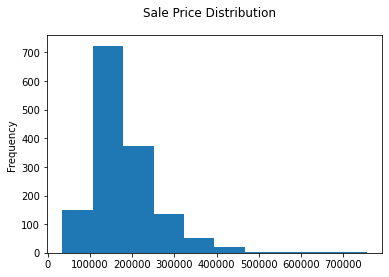

In [31]:
ax = new_train_frontage['SalePrice'].astype(int).plot(kind='hist',subplots=True,sharex=True,sharey=True,title='Sale Price Distribution')

Scatterplots will allows us to understand a relationship between two variables and it is useful for identifying outliers.

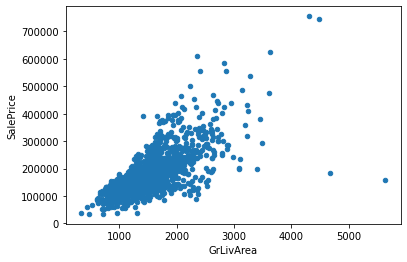

In [32]:
new_train_frontage.plot(kind='scatter', x='GrLivArea', y='SalePrice')

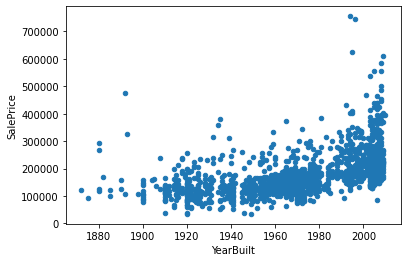

In [33]:
new_train_frontage.plot(kind='scatter', x='YearBuilt', y='SalePrice')

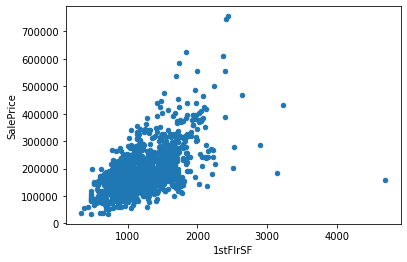

In [34]:
new_train_frontage.plot(kind='scatter', x='1stFlrSF', y='SalePrice')

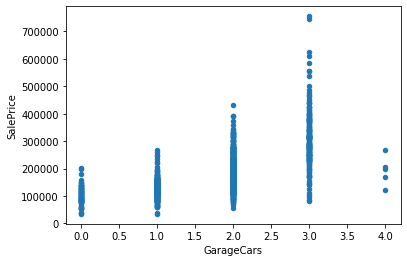

In [35]:
new_train_frontage.plot(kind='scatter', x='GarageCars', y='SalePrice')

In [36]:
# Removing Outliers
without_outlier_train = new_train_frontage[new_train_frontage['GrLivArea'].between(0, 4000)]
without_outlier_train = without_outlier_train[without_outlier_train['TotalBsmtSF'].between(0, 3000)]
without_outlier_train = without_outlier_train[without_outlier_train['SalePrice'].between(0, 450000)]
without_outlier_train = without_outlier_train[without_outlier_train['1stFlrSF'].between(0, 2500)]
without_outlier_train = without_outlier_train[without_outlier_train['YearBuilt'].between(1900, 2200)]
without_outlier_train = without_outlier_train[without_outlier_train['GarageCars'].between(0, 3)]

without_outlier_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,7,5,PConc,7,5,0,7,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,7,8,Typ,0,0,Attchd,2003,RFn,2,548,5,5,Y,0,61,0,0,0,0,0,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,5,5,CBlock,7,5,7,5,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,5,6,Typ,1,5,Attchd,1976,RFn,2,460,5,5,Y,298,0,0,0,0,0,0,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,7,5,PConc,7,5,3,7,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,7,6,Typ,1,5,Attchd,2001,RFn,2,608,5,5,Y,0,42,0,0,0,0,0,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,5,5,BrkTil,5,7,0,5,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,7,7,Typ,1,7,Detchd,1998,Unf,3,642,5,5,Y,0,35,272,0,0,0,0,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,7,5,PConc,7,5,5,7,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,7,9,Typ,1,5,Attchd,2000,RFn,3,836,5,5,Y,192,84,0,0,0,0,0,None,None,0,12,2008,WD,Normal,250000


In [37]:
without_outlier_train.shape

(1421, 81)

**Selecting features**

In [38]:
without_outlier_train.Street.value_counts()

Pave    1415
Grvl       6
Name: Street, dtype: int64

In [39]:
without_outlier_train.Utilities.value_counts()

AllPub    1420
NoSeWa       1
Name: Utilities, dtype: int64

In [40]:
without_outlier_train['PoolQC'].value_counts()

0    1416
7       2
3       2
9       1
Name: PoolQC, dtype: int64

In [41]:
# Removing columns which are not important for analysis (have too many one value or are repetitive)
without_outlier_train.drop(['Id', 'Street', 'Alley', 'Utilities', 'Condition2', 'RoofMatl', 
                     'Heating', 'Electrical', 
                     'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr',
                     '3SsnPorch', 'MiscFeature', 
                     'MiscVal', 'PoolQC'], axis=1, inplace=True)

new_test_frontage.drop(['Id', 'Street', 'Alley', 'Utilities', 'Condition2', 'RoofMatl', 
                     'Heating', 'Electrical', 
                     'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr',
                     '3SsnPorch', 'MiscFeature', 
                     'MiscVal', 'PoolQC'], axis=1, inplace=True)

Relationship with numerical variables

Text(0.5, 1.0, 'Fig.9 Heatmap of House variables')

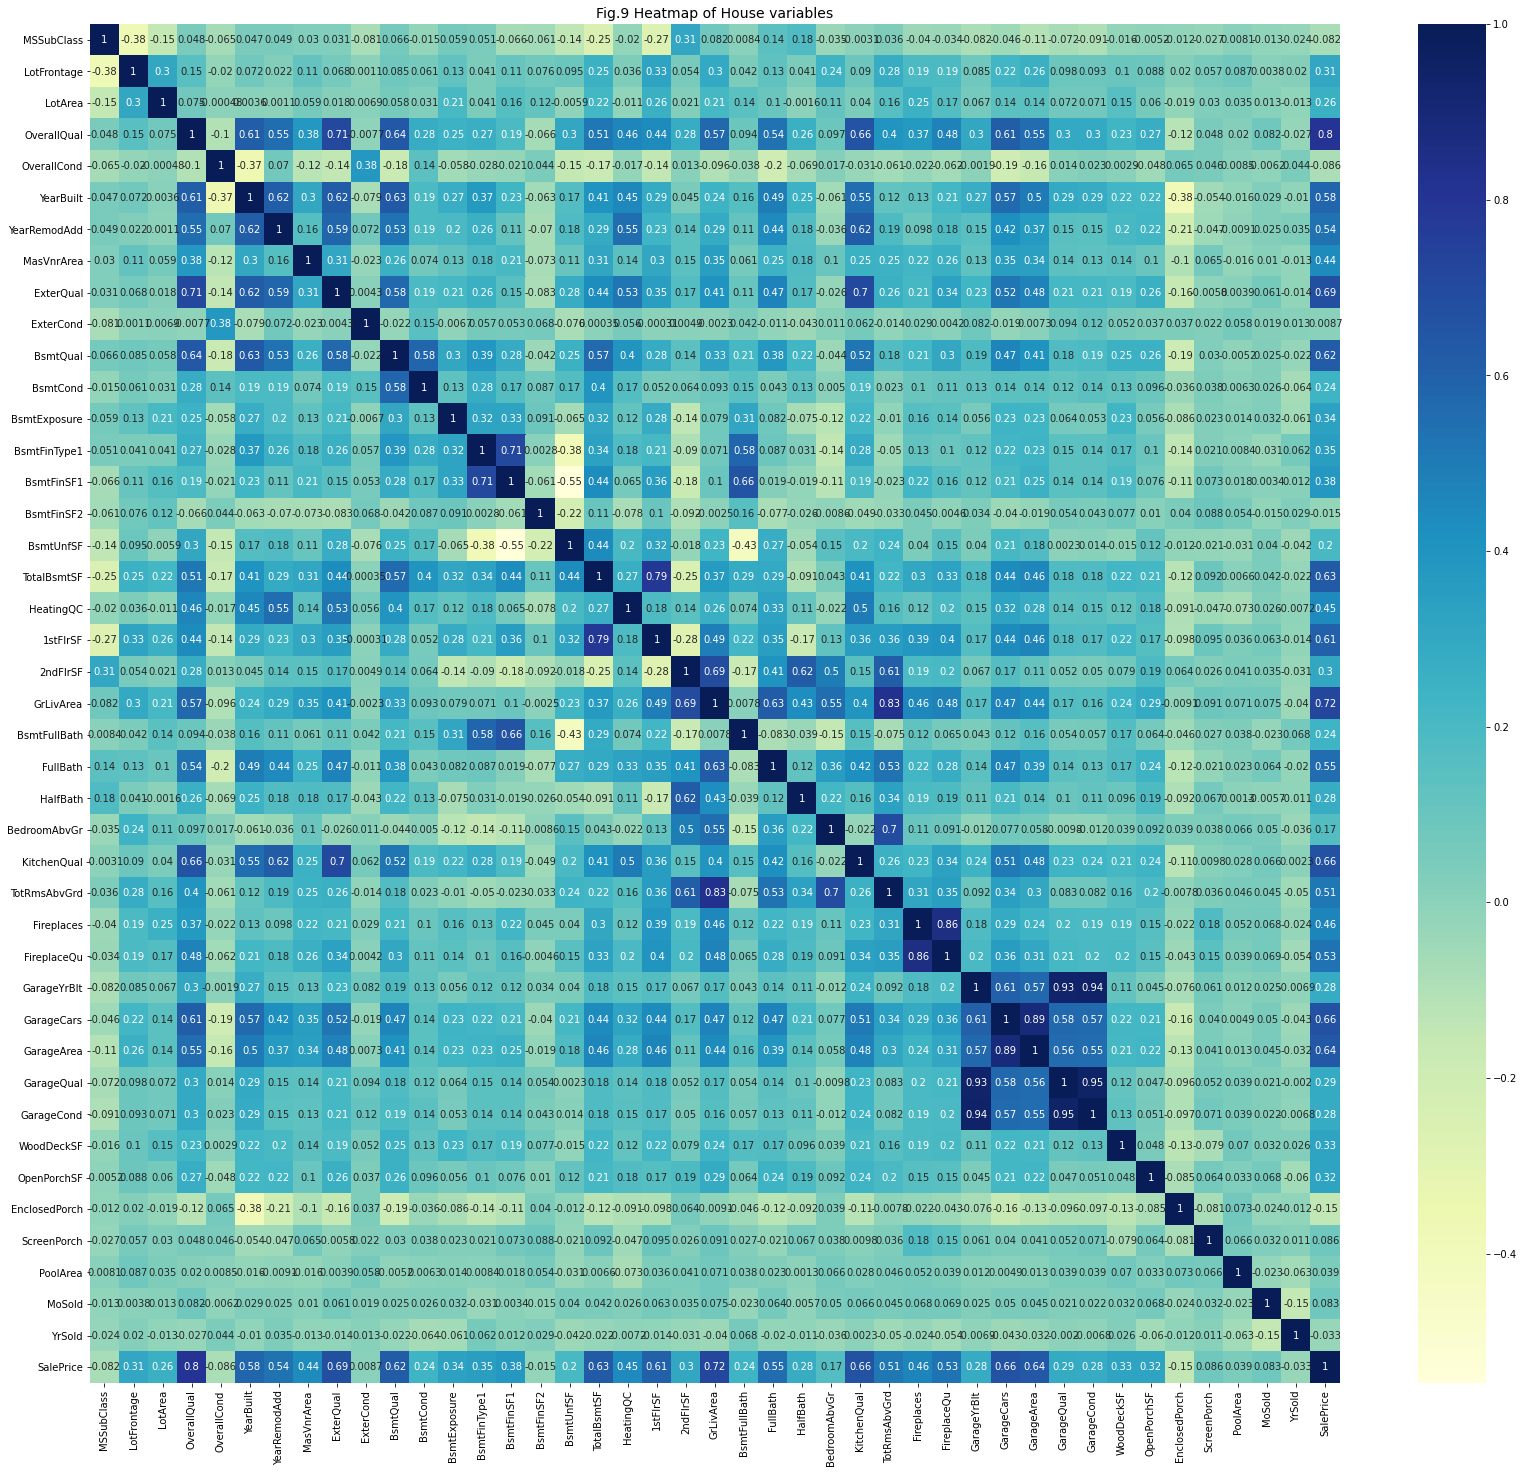

In [42]:
plt.figure(figsize=(28,25))
c = without_outlier_train.corr()
sns.heatmap(c, cmap='YlGnBu', annot=True)
plt.title('Fig.9 Heatmap of House variables', fontsize=14)

We can see that there is a positive correlation between Sale price and some of variables (OverallQual, YearBuilt, YearRemodAdd, KitchenQual, ExternalQual and others). This makes sense as newer or higher quality houses are generally more expensive.

Relationship with categorical features

In [43]:
without_outlier_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

MSZoning          5
LotShape          4
LandContour       4
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
BldgType          5
HouseStyle        8
RoofStyle         6
Exterior1st      15
Exterior2nd      16
MasVnrType        4
Foundation        6
BsmtFinType2      7
CentralAir        2
Functional        7
GarageType        7
GarageFinish      4
PavedDrive        3
Fence             5
SaleType          9
SaleCondition     6
dtype: int64

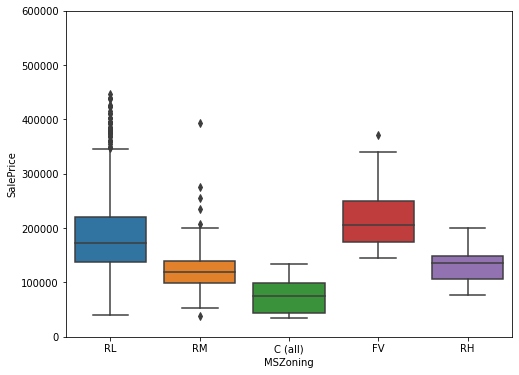

In [44]:
var = 'MSZoning'
data = pd.concat([without_outlier_train['SalePrice'], without_outlier_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=600000);

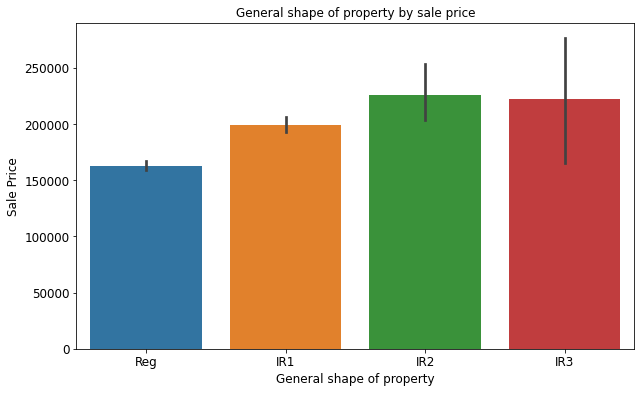

In [45]:
plt.figure(figsize=(10, 6))
sns.barplot(data=without_outlier_train, y='SalePrice', x='LotShape')
plt.title('General shape of property by sale price', fontsize=12)
plt.xlabel('General shape of property', fontsize=12)
plt.ylabel('Sale Price', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

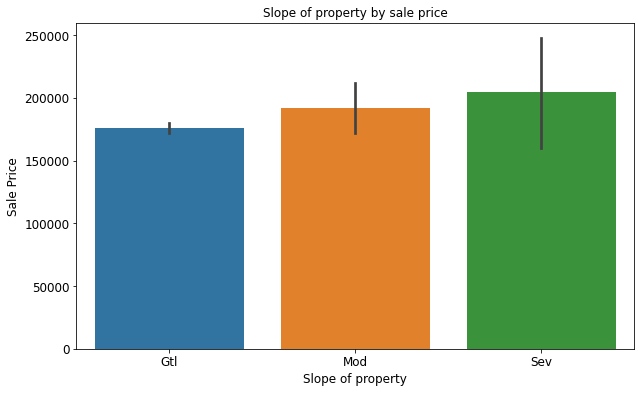

In [46]:
plt.figure(figsize=(10, 6))
sns.barplot(data=without_outlier_train, y='SalePrice', x='LandSlope')
plt.title('Slope of property by sale price', fontsize=12)
plt.xlabel('Slope of property', fontsize=12)
plt.ylabel('Sale Price', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


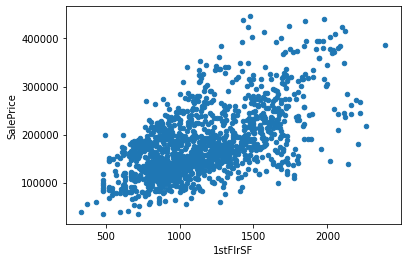

In [47]:
without_outlier_train.plot(kind='scatter', x='1stFlrSF', y='SalePrice')

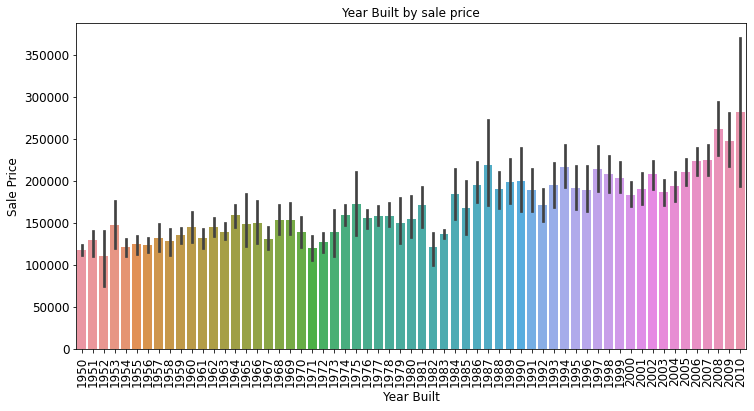

In [48]:
plt.figure(figsize=(12, 6))
sns.barplot(data=without_outlier_train, y='SalePrice', x='YearRemodAdd')
plt.title('Year Built by sale price', fontsize=12)
plt.xlabel('Year Built', fontsize=12)
plt.ylabel('Sale Price', fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.show()    

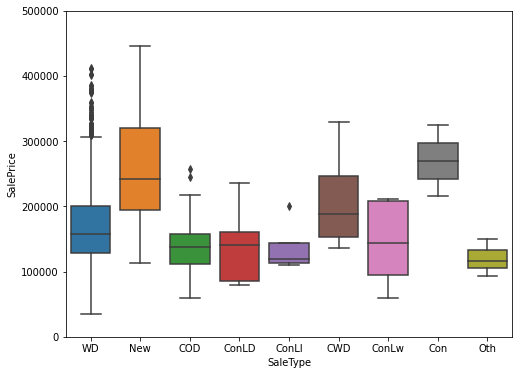

In [49]:
var = 'SaleType'
data = pd.concat([without_outlier_train['SalePrice'], without_outlier_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=500000);

In [50]:
neighborhood = without_outlier_train.Neighborhood.unique()
neighborhood.sort()

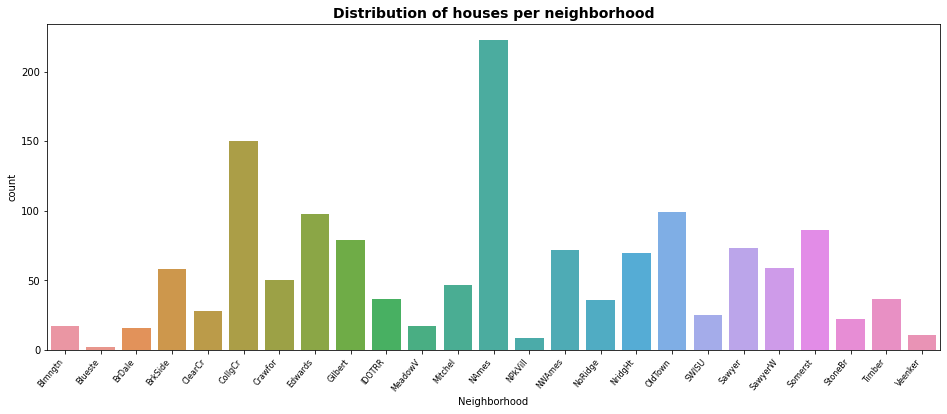

In [51]:
## Plotting an histogram with the neighborhoods sorted alphabetically. 
plt.figure(figsize=(16,6))
ax = sns.countplot(x='Neighborhood', data=without_outlier_train, order=neighborhood)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right", fontsize=8)
plt.title('Distribution of houses per neighborhood', fontsize=14, fontweight='bold')
plt.show()

After analysis of all the variables it was selected to remove few of them. 

In [52]:
to_remove = ['PavedDrive', 'GarageYrBlt', 'Functional', 'LandSlope', 'CentralAir']
final_train = without_outlier_train[without_outlier_train.columns.difference(to_remove)]
final_test = new_test_frontage[new_test_frontage.columns.difference(to_remove)]

In [ ]:
#final_train.info()

**Scaling numeric data**

In [53]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_train = final_train.select_dtypes(include=numerics).drop(['SalePrice'], 1)
num_test = final_test.select_dtypes(include=numerics)

scaler = StandardScaler()
scaled_train = scaler.fit_transform(num_train)
scaled_test = scaler.transform(num_test)

**Encoding categorical variables**

In [54]:
final_train.BsmtExposure.value_counts()

0    970
5    217
7    122
3    112
Name: BsmtExposure, dtype: int64

In [55]:
final_train.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtQual,BsmtUnfSF,Condition1,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GrLivArea,HalfBath,HeatingQC,HouseStyle,KitchenQual,LandContour,LotArea,LotConfig,LotFrontage,LotShape,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PoolArea,RoofStyle,SaleCondition,SalePrice,SaleType,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,3,1Fam,5,0,706,0,7,Unf,1,7,150,Norm,0,5,7,VinylSd,VinylSd,None,0,0,PConc,2,548,2,5,RFn,5,Attchd,1710,1,9,2Story,7,Lvl,8450,Inside,65.0,Reg,60,RL,196,BrkFace,2,CollgCr,61,5,7,0,Gable,Normal,208500,WD,0,8,856,0,2003,2003,2008
1,1262,0,3,1Fam,5,7,978,0,5,Unf,0,7,284,Feedr,0,5,5,MetalSd,MetalSd,None,5,1,CBlock,2,460,2,5,RFn,5,Attchd,1262,0,9,1Story,5,Lvl,9600,FR2,80.0,Reg,20,RL,0,None,5,Veenker,0,8,6,0,Gable,Normal,181500,WD,0,6,1262,298,1976,1976,2007
2,920,866,3,1Fam,5,3,486,0,7,Unf,1,7,434,Norm,0,5,7,VinylSd,VinylSd,None,5,1,PConc,2,608,2,5,RFn,5,Attchd,1786,1,9,2Story,7,Lvl,11250,Inside,68.0,IR1,60,RL,162,BrkFace,9,CollgCr,42,5,7,0,Gable,Normal,223500,WD,0,6,920,0,2001,2002,2008
3,961,756,3,1Fam,7,0,216,0,5,Unf,1,5,540,Norm,272,5,5,Wd Sdng,Wd Shng,None,7,1,BrkTil,1,642,3,5,Unf,5,Detchd,1717,0,7,2Story,7,Lvl,9550,Corner,60.0,IR1,70,RL,0,None,2,Crawfor,35,5,7,0,Gable,Abnorml,140000,WD,0,7,756,0,1915,1970,2006
4,1145,1053,4,1Fam,5,5,655,0,7,Unf,1,7,490,Norm,0,5,7,VinylSd,VinylSd,None,5,1,PConc,2,836,3,5,RFn,5,Attchd,2198,1,9,2Story,7,Lvl,14260,FR2,84.0,IR1,60,RL,350,BrkFace,12,NoRidge,84,5,8,0,Gable,Normal,250000,WD,0,9,1145,192,2000,2000,2008


In [56]:
final_train.select_dtypes('object').columns

Index(['BldgType', 'BsmtFinType2', 'Condition1', 'Exterior1st', 'Exterior2nd',
       'Fence', 'Foundation', 'GarageFinish', 'GarageType', 'HouseStyle',
       'LandContour', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType',
       'Neighborhood', 'RoofStyle', 'SaleCondition', 'SaleType'],
      dtype='object')

In [57]:
final_test.select_dtypes('object').columns

Index(['BldgType', 'BsmtFinType2', 'Condition1', 'Exterior1st', 'Exterior2nd',
       'Fence', 'Foundation', 'GarageFinish', 'GarageType', 'HouseStyle',
       'LandContour', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType',
       'Neighborhood', 'RoofStyle', 'SaleCondition', 'SaleType'],
      dtype='object')

In [58]:
final_train['Exterior1st'].replace({'BrkComm':'other', 'CBlock':'other', 'ImStucc':'other', 'AsphShn':'other','Stone':'other'}, inplace=True)
final_test['Exterior1st'].replace({'BrkComm':'other', 'CBlock':'other', 'ImStucc':'other', 'AsphShn':'other','Stone':'other'}, inplace=True)

final_train['Exterior2nd'].replace({'ImStucc':'other', 'Brk Cmn':'other', 'Stone':'other', 'AsphShn':'other', 'CBlock':'other'}, inplace=True)
final_test['Exterior2nd'].replace({'ImStucc':'other', 'Brk Cmn':'other', 'Stone':'other', 'AsphShn':'other', 'CBlock':'other'}, inplace=True)

final_train['Foundation'].replace({'Slab':'other', 'Stone':'other', 'Wood':'other'}, inplace=True)
final_test['Foundation'].replace({'Slab':'other', 'Stone':'other', 'Wood':'other'}, inplace=True)

final_train['GarageType'].replace({'Basment':'other', 'CarPort':'other', '2Types':'other'}, inplace=True)
final_test['GarageType'].replace({'Basment':'other', 'CarPort':'other', '2Types':'other'}, inplace=True)

final_train['HouseStyle'].replace({'1.5Unf':'other', '2.5Unf':'other', '2.5Fin':'other'}, inplace=True)
final_test['HouseStyle'].replace({'1.5Unf':'other', '2.5Unf':'other', '2.5Fin':'other'}, inplace=True)

final_train['LotConfig'].replace({'FR2':'other', 'FR3':'other'}, inplace=True)
final_test['LotConfig'].replace({'FR2':'other', 'FR3':'other'}, inplace=True)

final_train['LotShape'].replace({'IR2':'other', 'IR3':'other'}, inplace=True)
final_test['LotShape'].replace({'IR2':'other', 'IR3':'other'}, inplace=True)

final_train['MSZoning'].replace({'FV':'other', 'RH':'other', 'C (all)':'other'}, inplace=True)
final_test['MSZoning'].replace({'FV':'other', 'RH':'other', 'C (all)':'other'}, inplace=True)

final_train['RoofStyle'].replace({'Flat':'other', 'Gambrel':'other', 'Mansard':'other', 'Shed':'other'}, inplace=True)
final_test['RoofStyle'].replace({'Flat':'other', 'Gambrel':'other', 'Mansard':'other', 'Shed':'other'}, inplace=True)

final_train['SaleCondition'].replace({'Family':'other', 'Alloca':'other', 'AdjLand':'other'}, inplace=True)
final_test['SaleCondition'].replace({'Family':'other', 'Alloca':'other', 'AdjLand':'other'}, inplace=True)

final_train['SaleType'].replace({'ConLD':'other', 'ConLw':'other', 'CWD':'other', 'ConLI':'other', 'Oth':'other', 'Con':'other'}, inplace=True)
final_test['SaleType'].replace({'ConLD':'other', 'ConLw':'other', 'CWD':'other', 'ConLI':'other', 'Oth':'other', 'Con':'other'}, inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [59]:
final_train.SaleType.value_counts()

WD       1238
New       114
COD        42
other      27
Name: SaleType, dtype: int64

In [60]:
final_test.SaleType.value_counts()

WD       1259
New       117
COD        44
other      39
Name: SaleType, dtype: int64

In [61]:
final_train.shape

(1421, 61)

In [62]:
final_test.shape

(1459, 60)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5a7ee93490>,
      dtype=object)

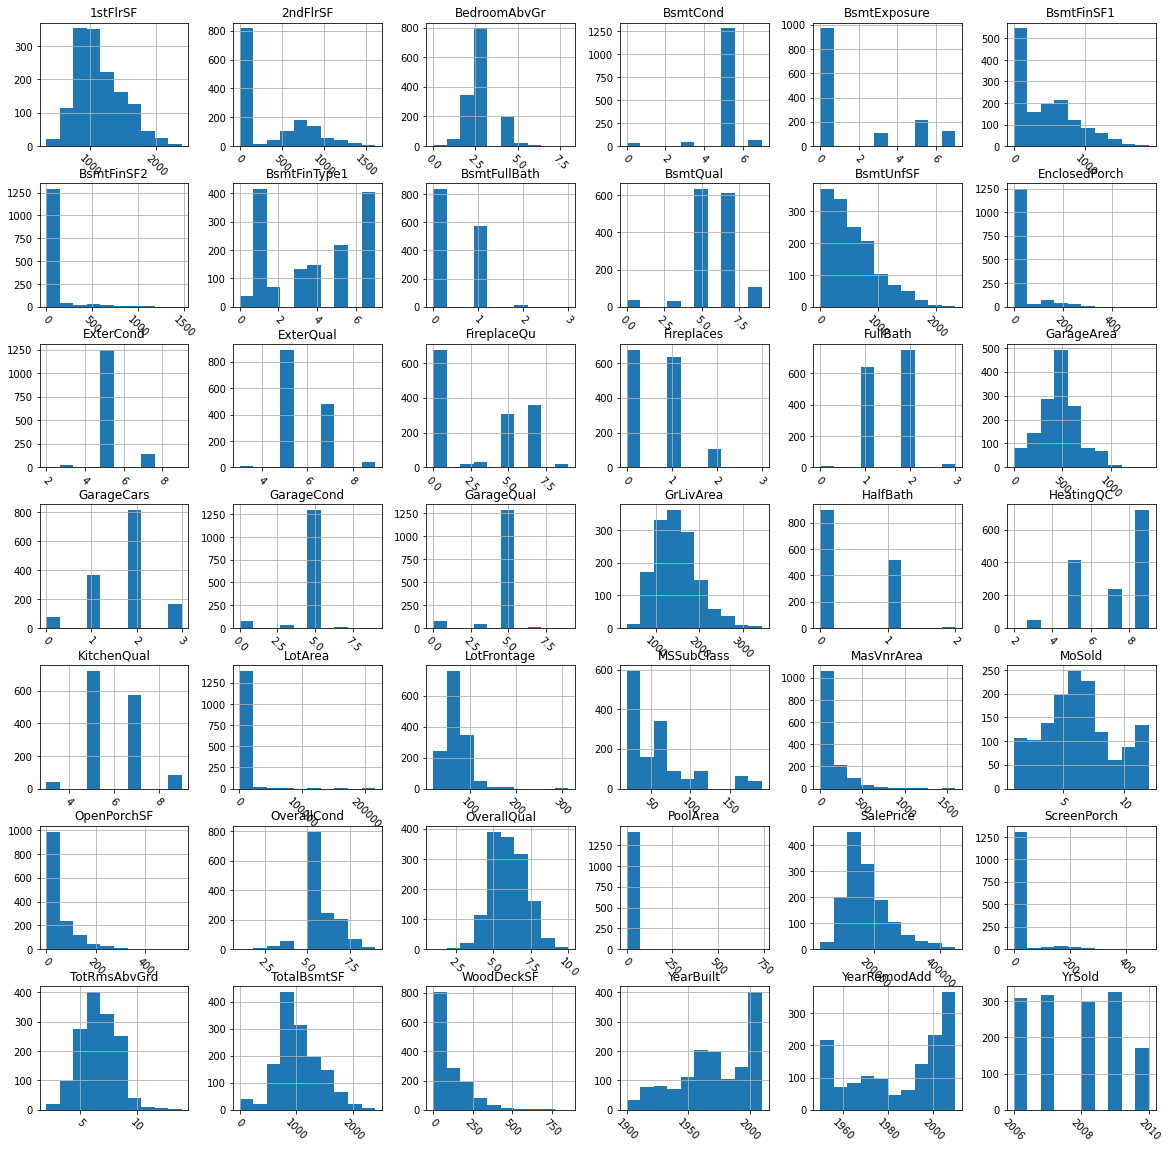

In [63]:
final_train.hist(figsize=(20,20), xrot=-45)

In [95]:
cols = ['BldgType', 'BsmtFinType2', 'Condition1', 'Exterior1st',
       'Exterior2nd', 'Fence', 'Foundation', 'GarageFinish', 'GarageType',
       'HouseStyle', 'LandContour', 'LotConfig', 'LotShape', 'MSZoning',
       'MasVnrType', 'Neighborhood', 'RoofStyle', 'SaleCondition', 'SaleType']

encoder = OneHotEncoder(drop='first', sparse=False)
enc_train = pd.DataFrame(encoder.fit_transform(final_train[cols]))
enc_train.columns = encoder.get_feature_names(['BldgType', 'BsmtFinType2', 'Condition1', 'Exterior1st',
       'Exterior2nd', 'Fence', 'Foundation', 'GarageFinish', 'GarageType',
       'HouseStyle', 'LandContour', 'LotConfig', 'LotShape', 'MSZoning',
       'MasVnrType', 'Neighborhood', 'RoofStyle', 'SaleCondition', 'SaleType'])

enc_test = pd.DataFrame(encoder.fit_transform(final_test[['BldgType', 'BsmtFinType2', 'Condition1', 'Exterior1st',
       'Exterior2nd', 'Fence', 'Foundation', 'GarageFinish', 'GarageType',
       'HouseStyle', 'LandContour', 'LotConfig', 'LotShape', 'MSZoning',
       'MasVnrType', 'Neighborhood', 'RoofStyle', 'SaleCondition', 'SaleType']]))
enc_test.columns = encoder.get_feature_names(['BldgType', 'BsmtFinType2', 'Condition1', 'Exterior1st',
       'Exterior2nd', 'Fence', 'Foundation', 'GarageFinish', 'GarageType',
       'HouseStyle', 'LandContour', 'LotConfig', 'LotShape', 'MSZoning',
       'MasVnrType', 'Neighborhood', 'RoofStyle', 'SaleCondition', 'SaleType'])

Features and target

In [67]:
# Joining scaled and encoded data
features = np.concatenate([scaled_train, enc_train], axis=-1,)
#features_not_scaled = np.concatenate([num_train, enc_train], axis=-1,)
target = final_train['SalePrice']
features_test = np.concatenate([scaled_test, enc_test], axis=-1,)
#features_test_not_scaled = pd.DataFrame(np.concatenate([num_test, enc_test], axis=-1,))


In [69]:
x_train, x_val, y_train, y_val = train_test_split(features, target, test_size = 0.2, random_state = 7)
print('Number of training samples is', x_train.shape[0])
print('Number of validation samples is', x_val.shape[0])

Number of training samples is 1136
Number of validation samples is 285


**Linear Regression - Lasso**

In [97]:
!pip install eli5

     |████████████████████████████████| 112kB 5.1MB/s 


In [98]:
import eli5 
eli5.sklearn.explain_weights

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.



<module 'eli5.sklearn.explain_weights' from '/usr/local/lib/python3.7/dist-packages/eli5/sklearn/explain_weights.py'>

In [108]:
eli5.sklearn.explain_weights.explain_weights(regr, feature_names=features)

AttributeError: ignored

In [71]:
lasso = Lasso(max_iter=1000, random_state=5)

# list of alphas
params = {'alpha': [20, 25, 27, 30, 35, 45, 50]}

# cross validation
folds = 5
lasso_model_cv = GridSearchCV(estimator = lasso,                         
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True)            

lasso_model_cv.fit(features, target)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=5,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [20, 25, 27, 30, 35, 45, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=0)

In [72]:
lasso_cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
lasso_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
3,30,-13283.897908,-15060.271220,1
4,35,-13327.944314,-15063.429272,2
2,27,-13257.796650,-15064.066410,3
0,20,-13204.710261,-15064.516507,4
1,25,-13241.150019,-15066.642969,5
5,45,-13412.934964,-15087.191710,6
6,50,-13456.478240,-15100.523888,7


In [73]:
# get the best estimator for lambda
lasso_model_cv.best_estimator_

Lasso(alpha=30, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=5, selection='cyclic',
      tol=0.0001, warm_start=False)

In [74]:
# check the coefficient values with lambda = 30
alpha = 30
lasso_model = Lasso(alpha=alpha, max_iter=1000)
lasso_model.fit(features, target)

Lasso(alpha=30, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [75]:
predicted_lasso_model = lasso_model.predict(features_test)

In [76]:
predicted_lasso_model = pd.DataFrame(predicted_lasso_model, columns=['SalePrice'])
test_id_df = test[['Id']]
prediction_lasso_model = pd.concat([test_id_df, predicted_lasso_model], axis=1, ignore_index=False)
prediction_lasso_model.shape

(1459, 2)

In [77]:
prediction_lasso_model.head()

,Id,SalePrice
0,1461,111411.446910
1,1462,170860.592279
2,1463,180230.505360
3,1464,191900.126329
4,1465,202210.397975


In [78]:
prediction_lasso_model.to_csv('prediction_lasso.csv', index=False)

Kaggle score - 0.13899

In [79]:
predicted_lasso_x_val = lasso_model.predict(x_val)

In [80]:
rmsle_lasso = np.sqrt(mean_squared_log_error(y_val,predicted_lasso_x_val))
print(rmsle_lasso)

0.11202600818031423


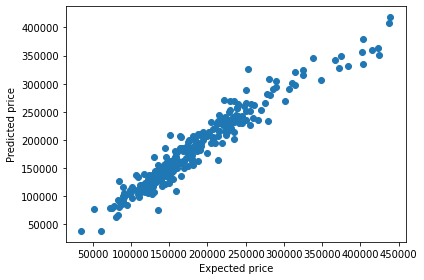

In [81]:
plt.scatter(y_val, predicted_lasso_x_val)
plt.axis('tight')
plt.xlabel('Expected price')
plt.ylabel('Predicted price')
plt.tight_layout()


**Random forest**

In [82]:
regr = RandomForestRegressor(max_depth=10, random_state=0)

In [83]:
random_forest_cv = cross_validate(regr, features, np.log10(target), cv=5, scoring=('neg_root_mean_squared_error'), return_train_score=True)
print(f"Random Forest Regression RMSE: test_score: {-1*np.mean(random_forest_cv['test_score'])}, train_score: {-1*np.mean(random_forest_cv['train_score'])}")

Random Forest Regression RMSE: test_score: 0.060357797609096465, train_score: 0.025815746657206602


In [84]:
regr.fit(features, target)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [85]:
predicted_rand_for = regr.predict(features_test)

In [86]:
predicted_rand_for = pd.DataFrame(predicted_rand_for, columns=['SalePrice'])
predicted_rand_for = pd.concat([test_id_df, predicted_rand_for], axis=1, ignore_index=False)
predicted_rand_for.shape

(1459, 2)

In [87]:
predicted_rand_for.head()

,Id,SalePrice
0,1461,125946.602907
1,1462,152252.120326
2,1463,184292.631375
3,1464,185526.848781
4,1465,200647.203533


In [89]:
predicted_rand_for.to_csv('prediction_random_forest.csv', index=False)

In [90]:
regr.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [91]:
predicted_random_forest_split = regr.predict(x_val)

In [92]:
rmsle_rf_split = np.sqrt(mean_squared_log_error(y_val, predicted_random_forest_split))
print(rmsle_rf_split)

0.14463094179872127


Kaggle score - 0.14992

In [93]:
data = {'Model':['Lasso', 'Random Forest'],
        'RSME':[0.11202, 0.14463],
        'Kaggle score':[0.13899, 0.14992],
        }
df = pd.DataFrame(data)
df

,Model,RSME,Kaggle score
0,Lasso,0.11202,0.13899
1,Random Forest,0.14463,0.14992


As we can see from result above Lasso performs better. Lasso Regression can be used for feature selection because the coefficients of less important features are reduced to zero.